# Part 3: Random Forest

###

In [8]:
import sys
!{sys.executable} -m pip install pandas_profiling
!{sys.executable} -m pip install spacy
!{sys.executable} -m pip install nltk
!{sys.executable} -m pip install imblearn
!{sys.executable} -m pip install scikit-learn-intelex
!{sys.executable} -m spacy download en_core_web_md


  Using cached daal-2021.4.0-py2.py3-none-win_amd64.whl (69.0 MB)
  Using cached tbb-2021.7.1-py3-none-win_amd64.whl (278 kB)
  Attempting uninstall: tbb
    Found existing installation: TBB 0.2


ERROR: Cannot uninstall 'TBB'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


     ---------------------------------------- 42.8/42.8 MB 3.2 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import spacy
import nltk
import re
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import ADASYN, SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearnex import patch_sklearn, config_context
from sklearn.pipeline import make_pipeline
patch_sklearn() # SW AI Accelerator for Intel CPUs. EXCLUDE IF NOT USING INTEL CPU.

adasyn=ADASYN()
sb.set()

""" NOTE: SET YOUR PROJECT ROOT DIRECTORY HERE """
PROJ_DIR = r""
RANDOM_SPLIT_SEED = 11

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
#data=pd.read_csv('fake_job_postings.csv')
data = pd.read_csv(PROJ_DIR + r"\sc1015-project\dataset\fake_job_postings.csv")
data.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree

y = pd.DataFrame(data['fraudulent'])
X = pd.DataFrame(data[['telecommuting', 'has_company_logo', 'has_questions']])


In [6]:
def rate(confusion_matrix):
    TrueNe=confusion_matrix[0][0]/((confusion_matrix[0][0])+(confusion_matrix[0][1]))
    print("True Negative rate is: ", TrueNe)
    TruePos=confusion_matrix[1][1]/((confusion_matrix[1][1])+(confusion_matrix[1][0]))
    print("True Positive rate is: ", TruePos)
    FasNe=confusion_matrix[1][0]/((confusion_matrix[1][0])+(confusion_matrix[1][1]))
    print("False negative rate is: ", FasNe)
    FasPos=confusion_matrix[0][1]/((confusion_matrix[0][0])+(confusion_matrix[0][1]))
    print("False Positive rate is: ", FasPos)

For train model: 
True Negative rate is:  1.0
True Positive rate is:  0.0
False negative rate is:  1.0
False Positive rate is:  0.0
For test model: 
True Negative rate is:  1.0
True Positive rate is:  0.0
False negative rate is:  1.0
False Positive rate is:  0.0


[Text(0.5, 0.875, 'has_company_logo <= 0.5\ngini = 0.092\nsamples = 14304\nvalue = [13609, 695]\nclass = real'),
 Text(0.25, 0.625, 'has_questions <= 0.5\ngini = 0.272\nsamples = 2895\nvalue = [2426, 469]\nclass = real'),
 Text(0.125, 0.375, 'telecommuting <= 0.5\ngini = 0.302\nsamples = 2132\nvalue = [1736, 396]\nclass = real'),
 Text(0.0625, 0.125, 'gini = 0.295\nsamples = 2035\nvalue = [1669, 366]\nclass = real'),
 Text(0.1875, 0.125, 'gini = 0.427\nsamples = 97\nvalue = [67, 30]\nclass = real'),
 Text(0.375, 0.375, 'telecommuting <= 0.5\ngini = 0.173\nsamples = 763\nvalue = [690, 73]\nclass = real'),
 Text(0.3125, 0.125, 'gini = 0.169\nsamples = 720\nvalue = [653, 67]\nclass = real'),
 Text(0.4375, 0.125, 'gini = 0.24\nsamples = 43\nvalue = [37, 6]\nclass = real'),
 Text(0.75, 0.625, 'telecommuting <= 0.5\ngini = 0.039\nsamples = 11409\nvalue = [11183, 226]\nclass = real'),
 Text(0.625, 0.375, 'has_questions <= 0.5\ngini = 0.037\nsamples = 10935\nvalue = [10728, 207]\nclass = real'

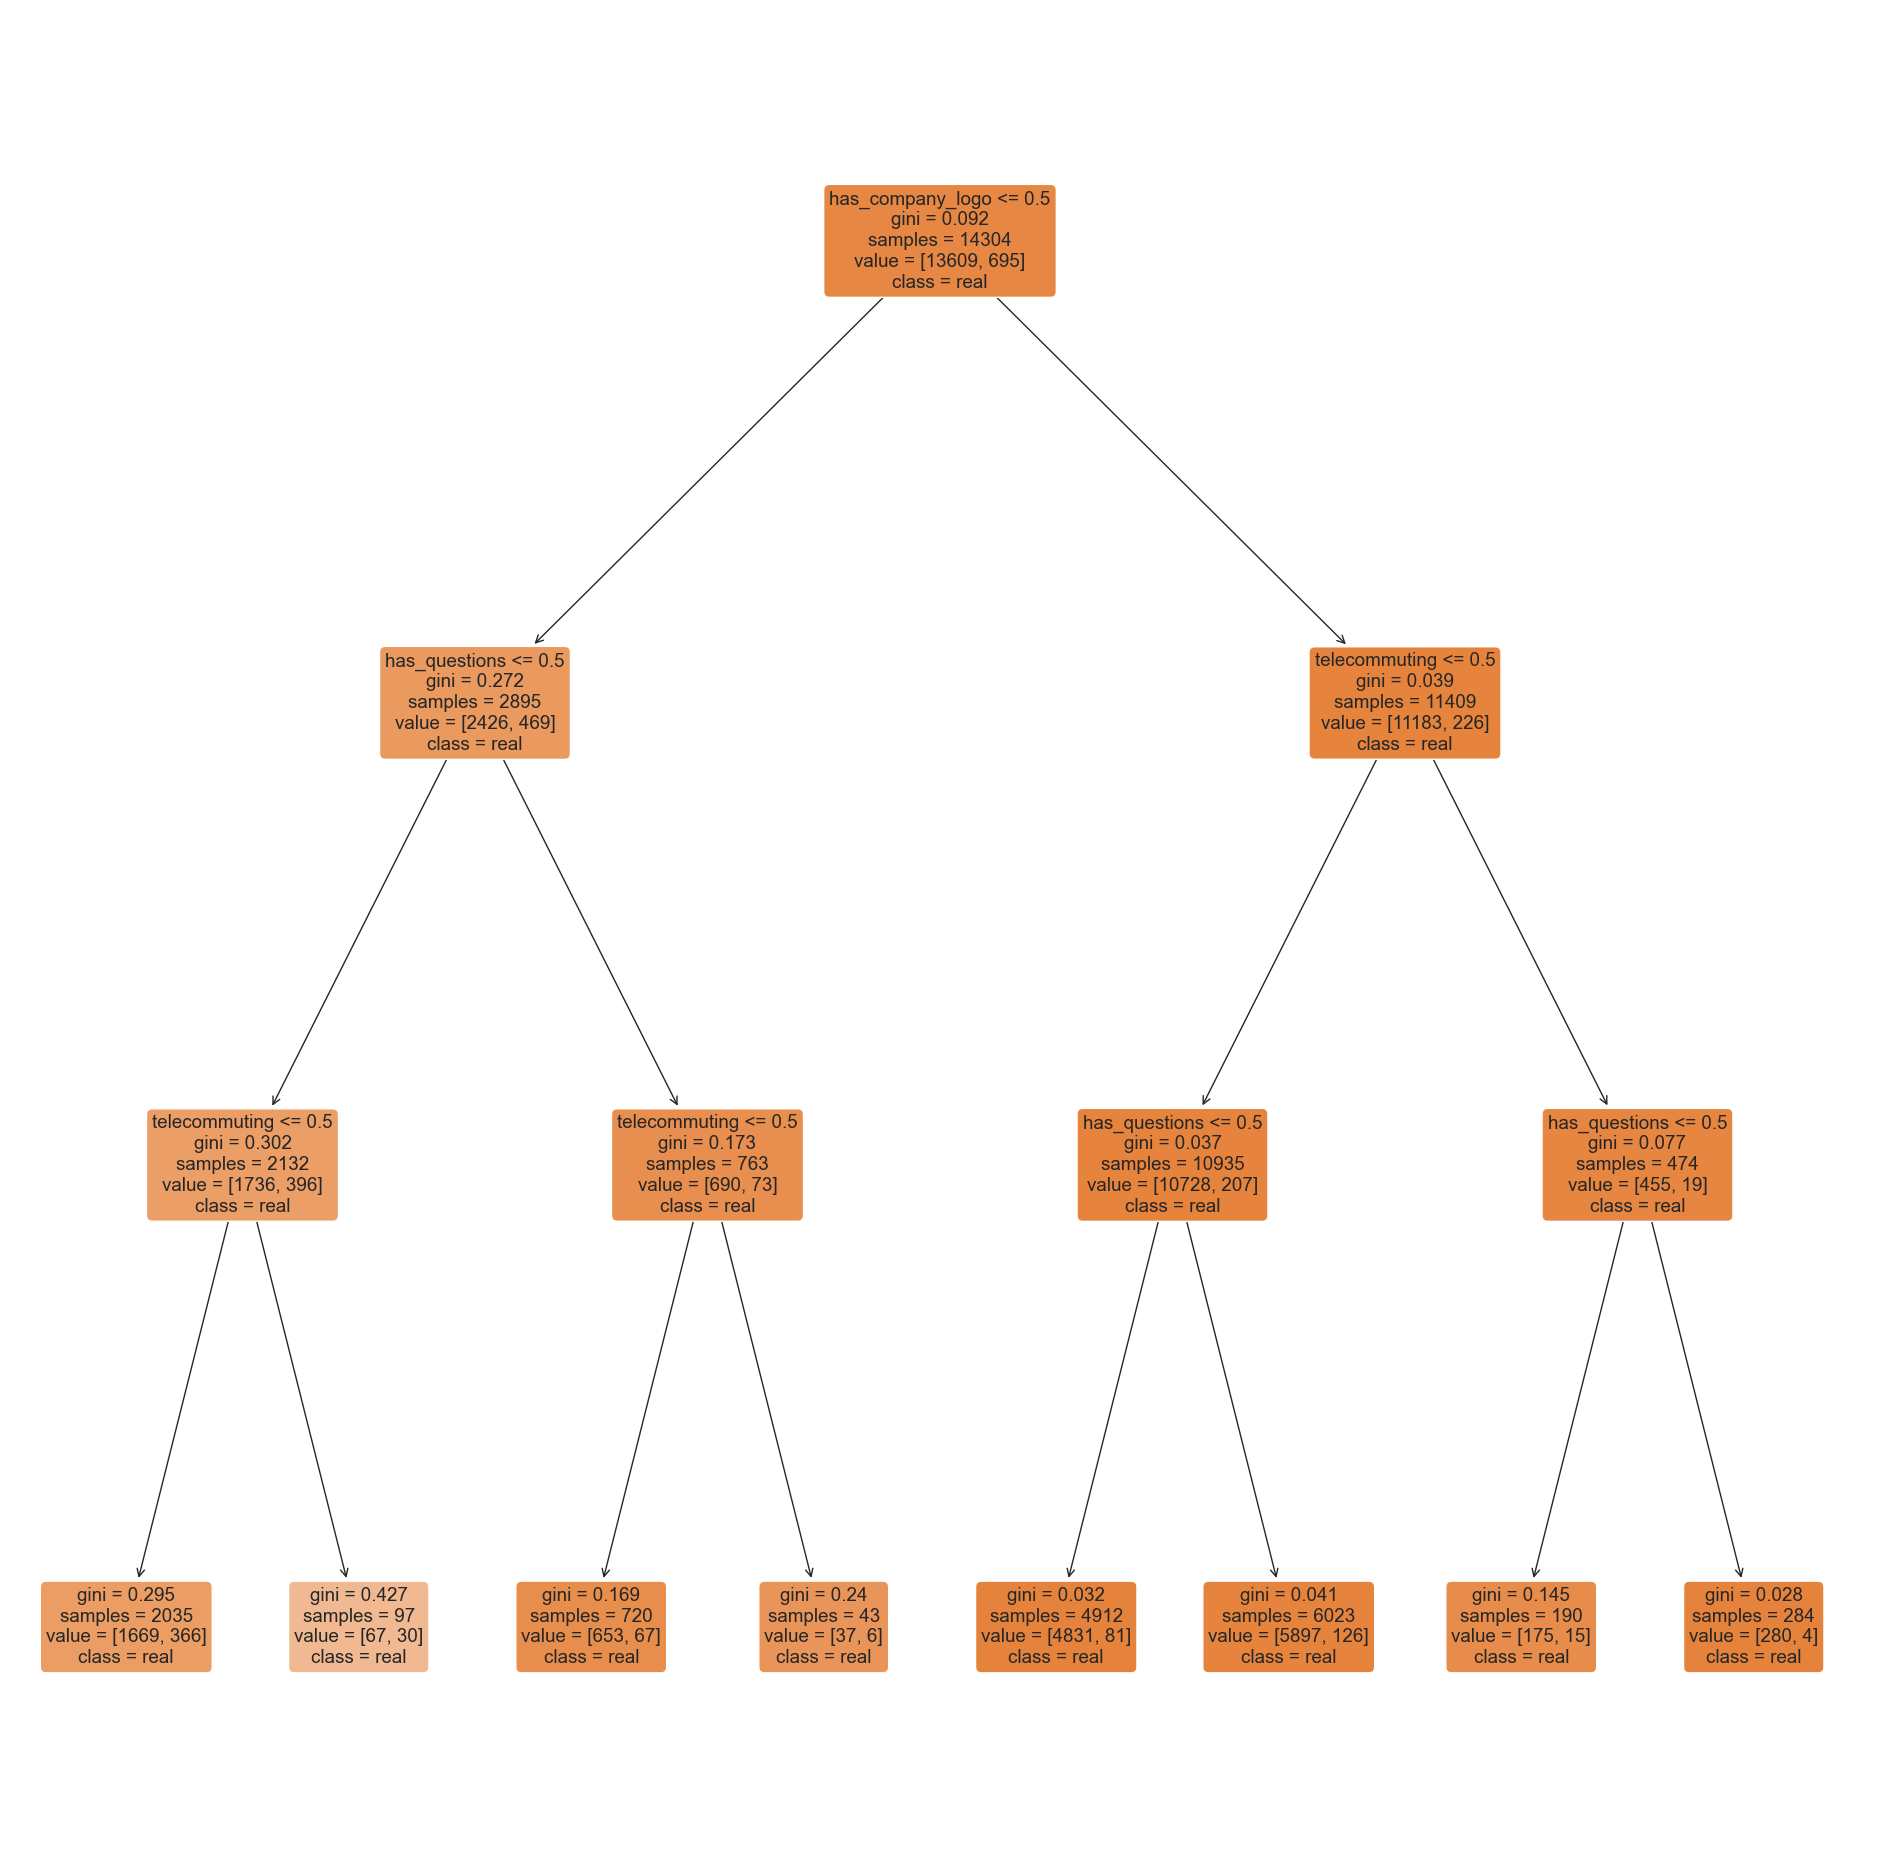

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

dectree = DecisionTreeClassifier(max_depth = 4)  
dectree.fit(X_train, y_train)       


y_train_predic=dectree.predict(X_train)
y_test_predic=dectree.predict(X_test)

print("For train model: ")
rate(confusion_matrix(y_train, y_train_predic))
print("For test model: ")
rate(confusion_matrix(y_test, y_test_predic))


f = plt.figure(figsize=(24,24))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=X_train.columns, 
          class_names=["real","false"])

<AxesSubplot:>

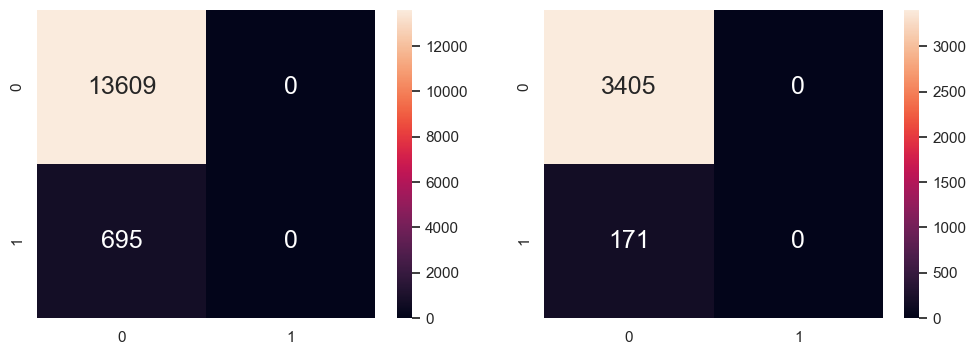

In [14]:
f, axes=plt.subplots(1, 2, figsize=(12,4))
sb.heatmap(confusion_matrix(y_train, y_train_predic), annot=True, fmt=".0f", annot_kws={"size":18}, ax=axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_predic), annot=True, fmt=".0f", annot_kws={"size":18}, ax=axes[1])

For train model: 
True Negative rate is:  1.0
True Positive rate is:  0.0
False negative rate is:  1.0
False Positive rate is:  0.0
For test model: 
True Negative rate is:  1.0
True Positive rate is:  0.0
False negative rate is:  1.0
False Positive rate is:  0.0


[Text(0.5, 0.875, 'has_company_logo <= 0.5\ngini = 0.092\nsamples = 14304\nvalue = [13609, 695]\nclass = real'),
 Text(0.25, 0.625, 'has_questions <= 0.5\ngini = 0.272\nsamples = 2895\nvalue = [2426, 469]\nclass = real'),
 Text(0.125, 0.375, 'telecommuting <= 0.5\ngini = 0.302\nsamples = 2132\nvalue = [1736, 396]\nclass = real'),
 Text(0.0625, 0.125, 'gini = 0.295\nsamples = 2035\nvalue = [1669, 366]\nclass = real'),
 Text(0.1875, 0.125, 'gini = 0.427\nsamples = 97\nvalue = [67, 30]\nclass = real'),
 Text(0.375, 0.375, 'telecommuting <= 0.5\ngini = 0.173\nsamples = 763\nvalue = [690, 73]\nclass = real'),
 Text(0.3125, 0.125, 'gini = 0.169\nsamples = 720\nvalue = [653, 67]\nclass = real'),
 Text(0.4375, 0.125, 'gini = 0.24\nsamples = 43\nvalue = [37, 6]\nclass = real'),
 Text(0.75, 0.625, 'telecommuting <= 0.5\ngini = 0.039\nsamples = 11409\nvalue = [11183, 226]\nclass = real'),
 Text(0.625, 0.375, 'has_questions <= 0.5\ngini = 0.037\nsamples = 10935\nvalue = [10728, 207]\nclass = real'

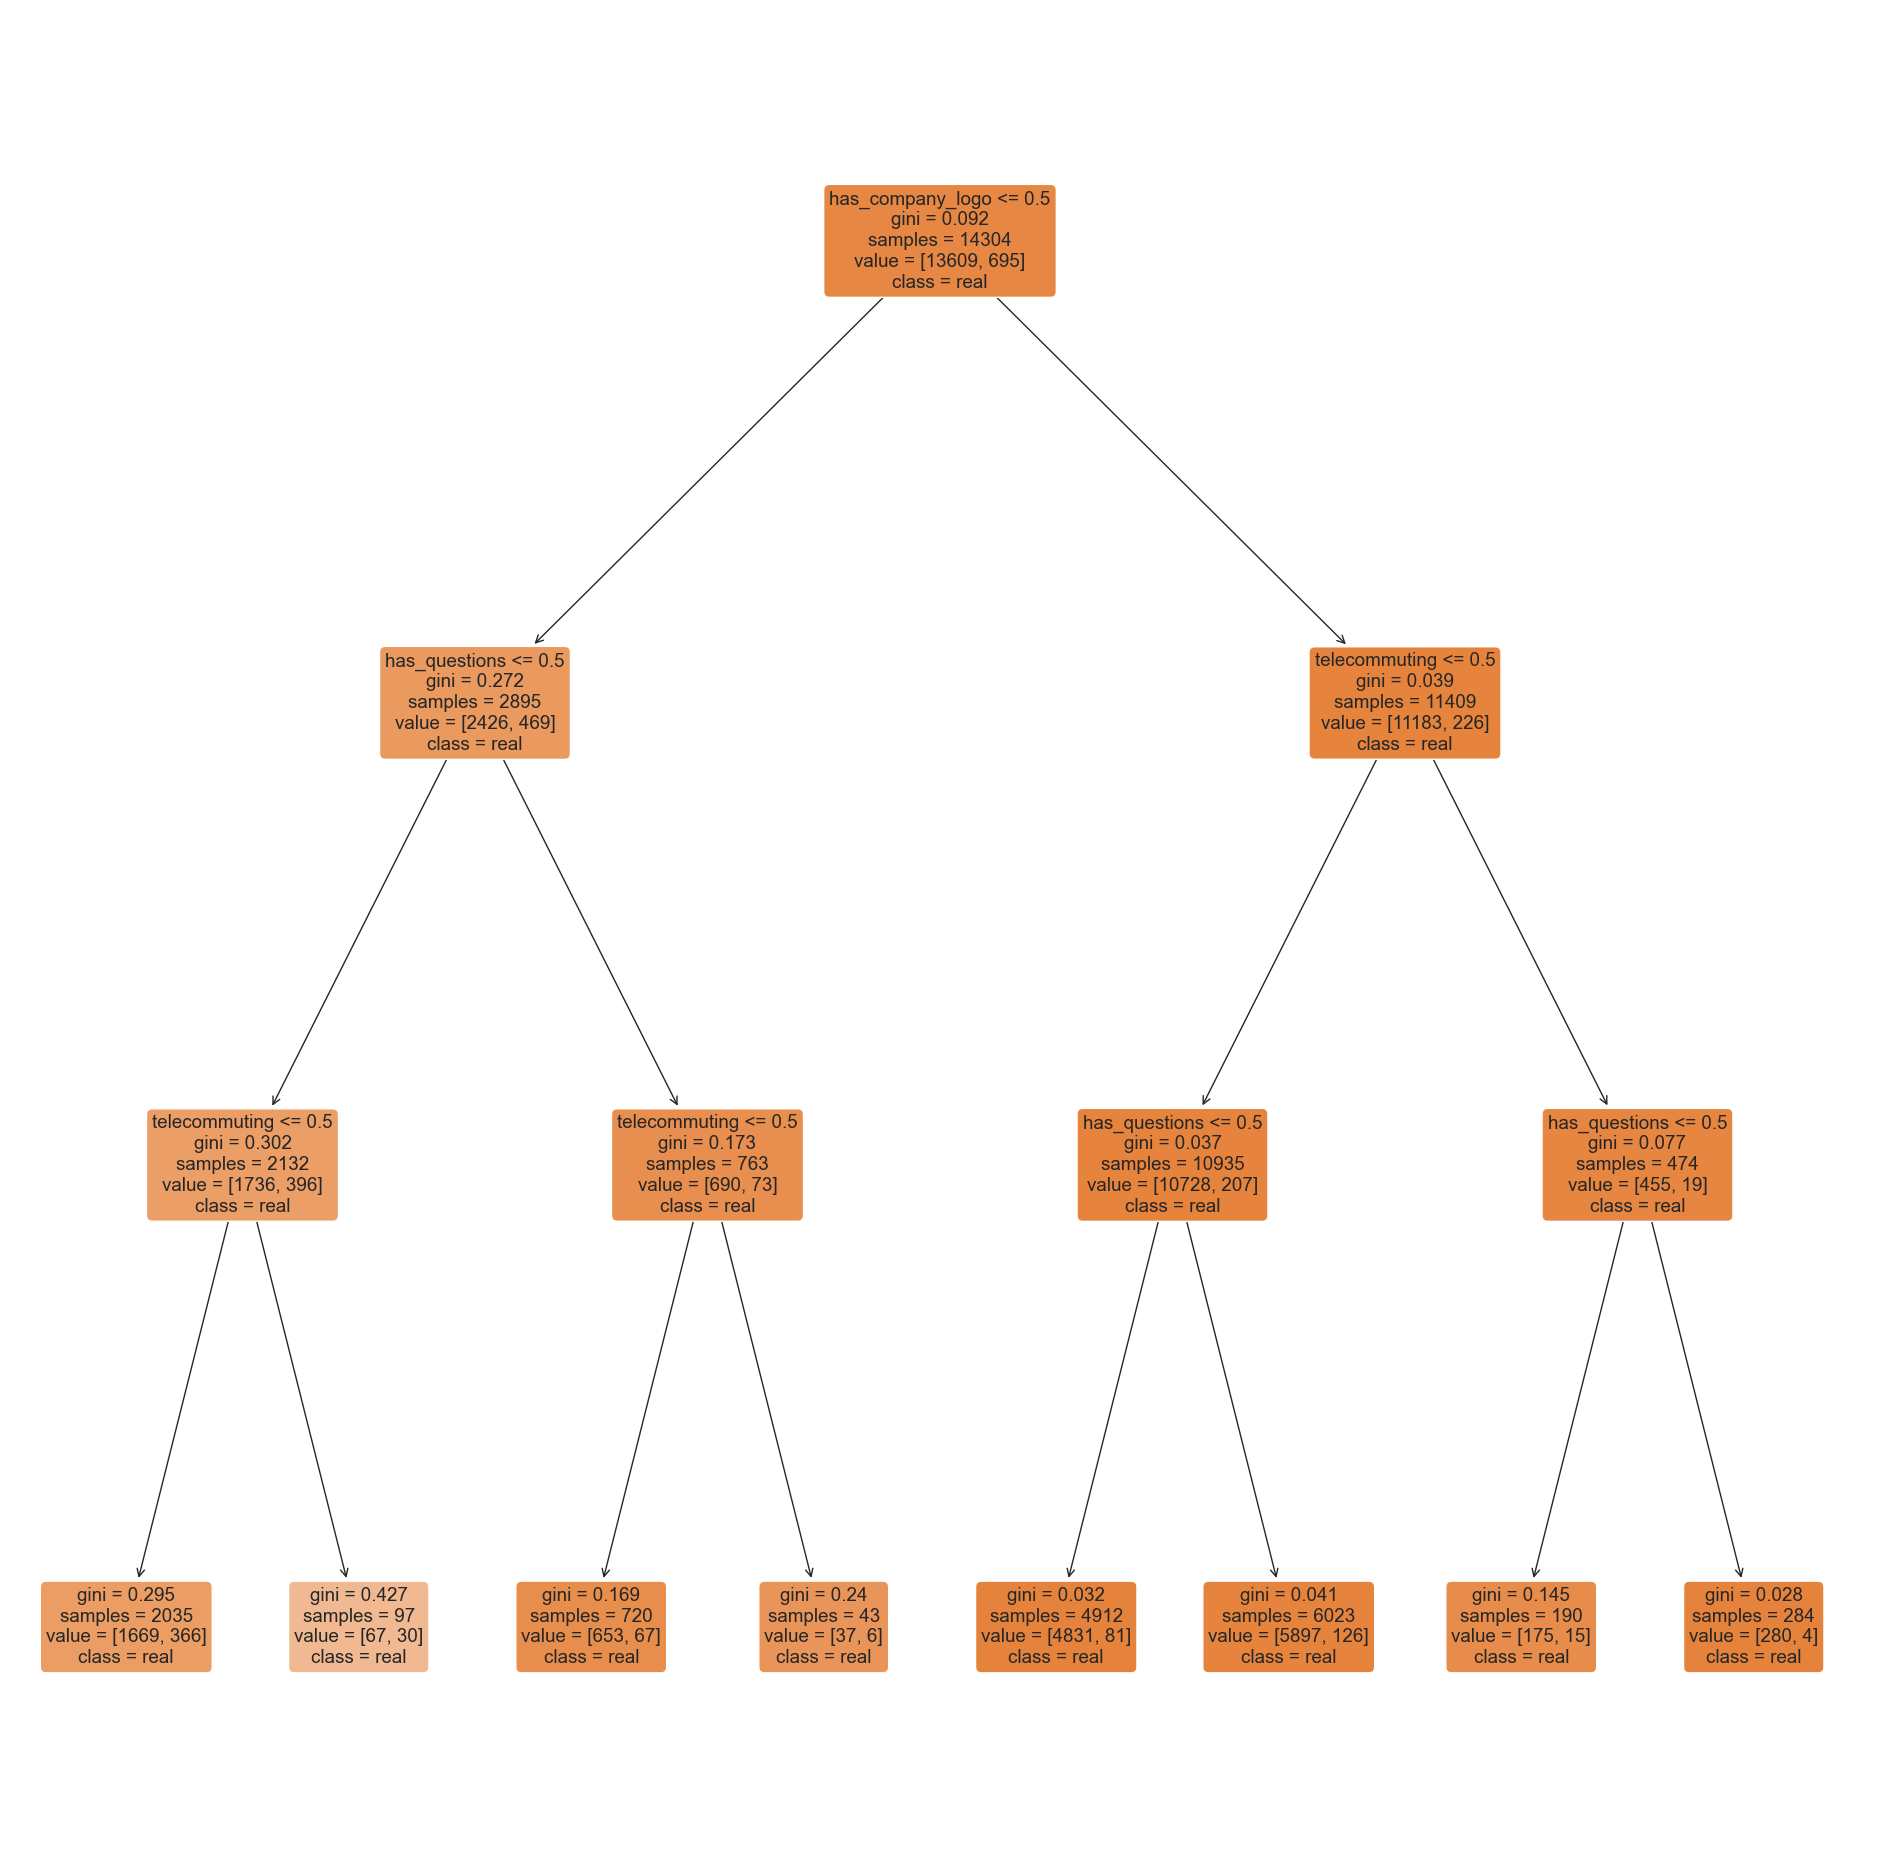

In [15]:
dectree = DecisionTreeClassifier(max_depth = 10)  
dectree.fit(X_train, y_train)


y_train_predic=dectree.predict(X_train)
y_test_predic=dectree.predict(X_test)

print("For train model: ")
rate(confusion_matrix(y_train, y_train_predic))
print("For test model: ")
rate(confusion_matrix(y_test, y_test_predic))


f = plt.figure(figsize=(24,24))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=X_train.columns, 
          class_names=["real","false"])

<AxesSubplot:>

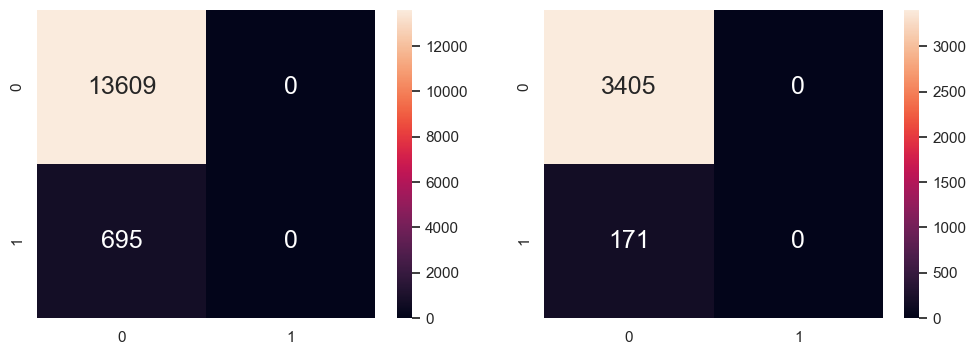

In [16]:
f, axes=plt.subplots(1, 2, figsize=(12,4))
sb.heatmap(confusion_matrix(y_train, y_train_predic), annot=True, fmt=".0f", annot_kws={"size":18}, ax=axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_predic), annot=True, fmt=".0f", annot_kws={"size":18}, ax=axes[1])

For train model: 
True Negative rate is:  1.0
True Positive rate is:  0.0
False negative rate is:  1.0
False Positive rate is:  0.0
For test model: 
True Negative rate is:  1.0
True Positive rate is:  0.0
False negative rate is:  1.0
False Positive rate is:  0.0


<AxesSubplot:>

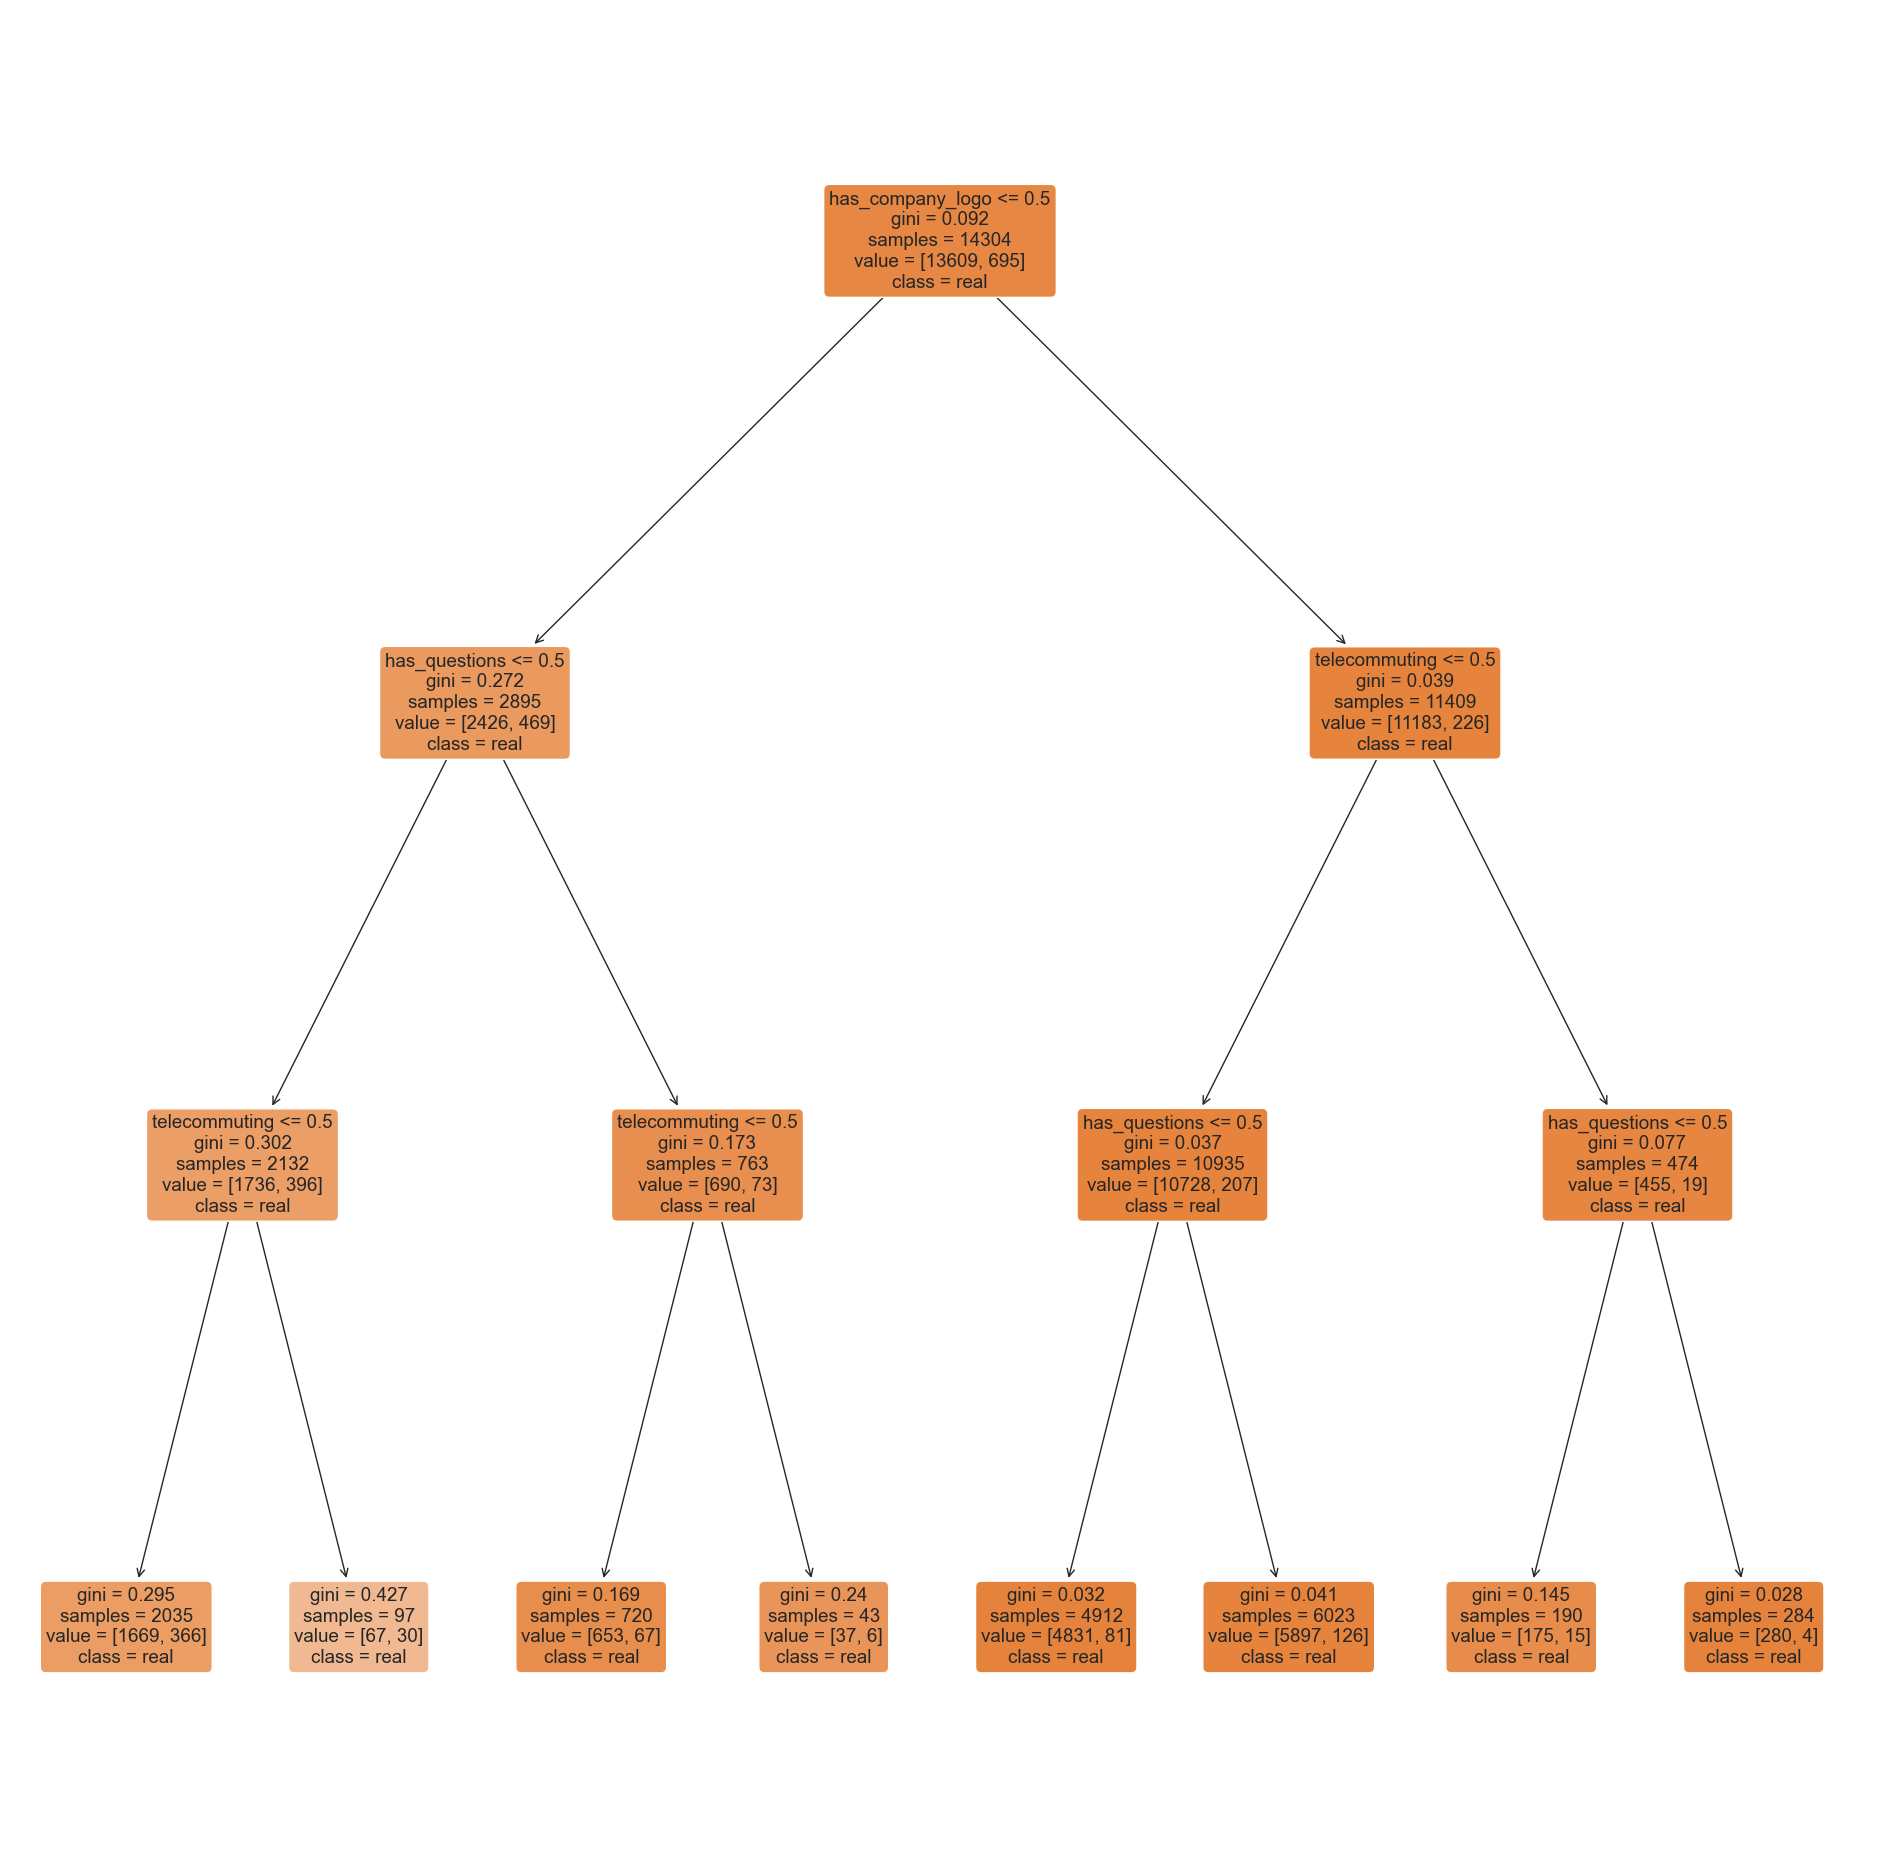

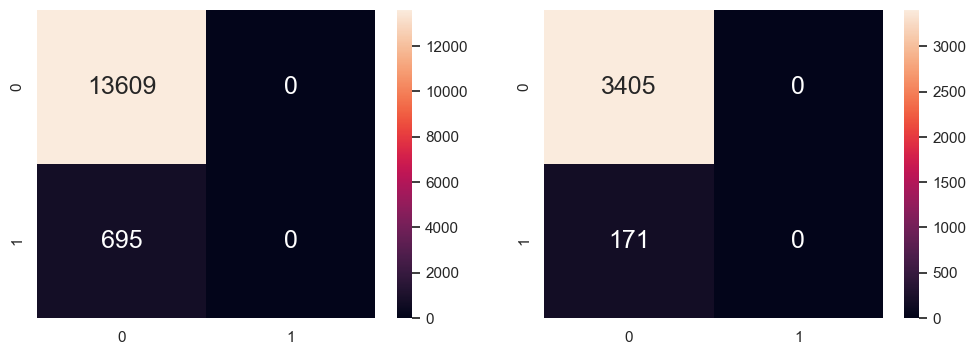

In [17]:
dectree = DecisionTreeClassifier(max_depth = 50)  
dectree.fit(X_train, y_train)       


y_train_predic=dectree.predict(X_train)
y_test_predic=dectree.predict(X_test)

print("For train model: ")
rate(confusion_matrix(y_train, y_train_predic))
print("For test model: ")
rate(confusion_matrix(y_test, y_test_predic))


f = plt.figure(figsize=(24,24))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=X_train.columns, 
          class_names=["real","false"])

f, axes=plt.subplots(1, 2, figsize=(12,4))
sb.heatmap(confusion_matrix(y_train, y_train_predic), annot=True, fmt=".0f", annot_kws={"size":18}, ax=axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_predic), annot=True, fmt=".0f", annot_kws={"size":18}, ax=axes[1])

As seen, the model used by decision trees has 1 true negative rate and 0 false positive rate, but it has very high false negative rate of 1 and very low true positive rate of 0. Which means that decision tree  might not be a good model to classify the fraudulent of this question. Also, there are only 3 parameters in the dataset is represented in numeric form, so only 3 parameters were used for modelling for drawing decision trees. 
In reality, using only 3 parameters for modelling for this model is insufficient. It is better to include all the parameters that are both represented in numeric and expression forms. 

Furthermore, the model of random forest has more advantages compared to using decision trees. Such advantages include lower variance due to the ensemble nature of random forest. Another advantage of using random forest compared to using decision tree model is to prevent overfit of the model. 

Then, In order to achieve this, all of the parameters excluding "fraudulent" was used for the model of random forest to help classify the fraudulent of this question. 

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import spacy
import nltk
import re
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import ADASYN, SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,make_scorer
from sklearn.svm import SVC
from sklearnex import patch_sklearn, config_context
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
patch_sklearn() # SW AI Accelerator for Intel CPUs. EXCLUDE IF NOT USING INTEL CPU.

adasyn=ADASYN()
sb.set()

""" NOTE: SET YOUR PROJECT ROOT DIRECTORY HERE """
PROJ_DIR = r""
RANDOM_SPLIT_SEED = 11

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [9]:
df = pd.read_csv(PROJ_DIR + r"\sc1015-project\dataset\fake_job_postings.csv")

cleaned_text = pd.read_csv('lemmatized_text.csv').squeeze() # convert to pd series
cleaned_text.head()

0     marketing intern us ny new york marketing mis...
1     customer service cloud video production nz  a...
2     commission machinery assistant cma us ia weve...
3     account executive washington dc us dc washing...
4     bill review manager us fl fort worth missing_...
Name: 0, dtype: object

In [10]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
vectorizer.fit(cleaned_text)
tfidf_data = vectorizer.transform(cleaned_text)
print(tfidf_data.shape)

(17880, 963648)


In [15]:
sss=StratifiedShuffleSplit(n_splits=1, random_state=RANDOM_SPLIT_SEED, test_size=0.2)
X=np.zeros(shape=tfidf_data.shape[0],dtype=np.bool_)
y=np.array(df['fraudulent']) # prediction target

for train_index, test_index in sss.split(X, y):
    X_train, X_test = tfidf_data[train_index,:], tfidf_data[test_index,:]
    y_train, y_test = y[train_index], y[test_index]

In [22]:
X_res, y_res = adasyn.fit_resample(X_train, y_train)


(27243, 185789)


In [29]:
from sklearn.ensemble import RandomForestClassifier

# Now, the Random Forest object is created:
ran_frt = RandomForestClassifier(n_estimators = 50,  
                                 max_depth = 32)  

# Random Forest is fitted on Train and Test Data:
ran_frt.fit(X_res, y_res)

RandomForestClassifier(max_depth=32, n_estimators=50)

In [33]:
train_predt=ran_frt.predict(X_res)
test_predt=ran_frt.predict(X_test)
print("The accuracy of train data set is: ", accuracy_score(train_predt, y_res))
print("The accuracy of test data set is: ", accuracy_score(test_predt, y_test))


The accuracy of train data set is:  0.9968432257827698
The accuracy of test data set is:  0.9787472035794184


In [38]:
print(metrics.classification_report(y_test, test_predt))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       0.99      0.57      0.72       173

    accuracy                           0.98      3576
   macro avg       0.98      0.78      0.85      3576
weighted avg       0.98      0.98      0.98      3576



<AxesSubplot:>

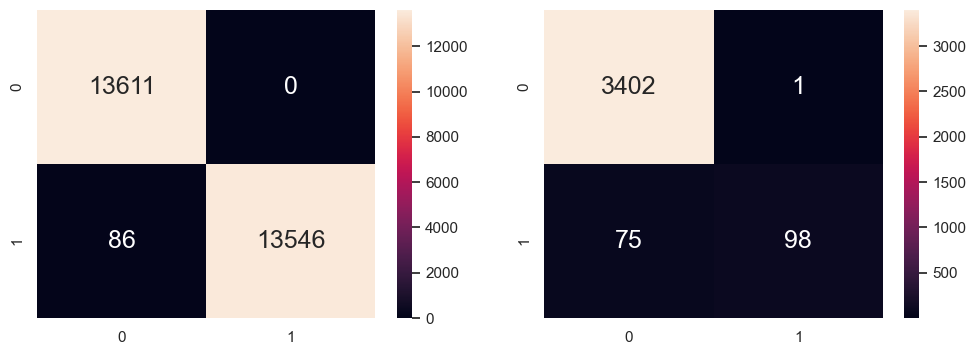

In [35]:
f, axes=plt.subplots(1, 2, figsize=(12,4))
sb.heatmap(confusion_matrix(y_res, train_predt), annot=True, fmt=".0f", annot_kws={"size":18}, ax=axes[0])
sb.heatmap(confusion_matrix(y_test, test_predt), annot=True, fmt=".0f", annot_kws={"size":18}, ax=axes[1])

In [ ]:
However, after using random forest model with all parameters excluding "fauludent" in the dataset, there is still lower f1-score although a

As seen, there is a highly umbalance proportion of real job and fake job in the dataset that is given.

Therefore, this question is not a normal classification type of problems, because it has highly imbalance fraudulent of jobs. As a consequence, this question cannot be solved simply by just using the approaches of drawing decision trees or random forest. There may need other models involving language processing and anaysis, such as Recurrent Neural Network(RNN) and Support Vector Classifier(SVC).